# Introduction: #4 Cluster Analysis

In this section, our goal is to identify product preference among customers using cluster analysis.

* We focus on our two main markets, __Northern America and Southern/Eastern Asia__, and implement clustering on items based on __product popularity and customer behavior__ for those two regions individually.

* After comparing the clustering performance of K-means Clustering with that of Kohonen Clustering Network by looking into the distance between clusters and standard deviations of each cluster, we choose the analysis results from __Kohonen Clustering Network, which performs better__ (standard deviations of most clusters are lower).

Finally, we group those top items among customers in Northern America and customers in Southern/Eastern Asia into __4 clusters__, determined by [the Elbow Method and the Silhouette Method](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Based on the top item lists for Northern America and Southern/Eastern Asia, we can prioritize promotions for those products, and create promotional strategies to improve our business in the future.

## Imports
We are using a typical data science stack such as `pandas`, `numpy`, and `sklearn`, which is one of the most important packages for clustering and other machine learning methods.

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import date, timedelta

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn_som.som import SOM

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = [10,6]

## Read in Data 

In [2]:
ecommerce_all = pd.read_csv('ecommerce_all.csv')
ecommerce_all['user_pseudo_id'] = ecommerce_all['user_pseudo_id'].astype(str)
ecommerce_all['ga_session_id'] = ecommerce_all['user_pseudo_id'].astype(str) + ecommerce_all['ga_session_id'].astype(str)
ecommerce_all['unique_session_id'] = ecommerce_all['event_date'].astype(str) + ecommerce_all['ga_session_id'].astype(str)
ecommerce_all.head()

,event_date,event_time,user_pseudo_id,continent,sub_continent,country,region,city,device_category,mobile_brand_name,mobile_model_name,operating_system,web_browser,revenue,traffic_name,traffic_medium,traffic_source,ga_session_id,event_name,event_value_in_usd,page_title,page_location,engagement_time_sec,total_item_quantity,purchase_revenue_in_usd,unique_items,transaction_id,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,quantity,item_revenue_in_usd,promotion_name,unique_session_id
0,20201103,2020-11-03 11:04:19,8825068.227430915,Europe,Southern Europe,(not set),(not set),(not set),desktop,Apple,Safari,Web,Chrome,0.0,(organic),organic,google,8825068.2274309152661157188,view_item,NaN,Eco-Friendly | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,3.075,NaN,NaN,12,(not set),GGOEGXXX1378,Google Cotopaxi Shell,(not set),(not set),Eco-Friendly,NaN,NaN,NaN,(not set),202011038825068.2274309152661157188
1,20201103,2020-11-03 07:43:31,10673312.893252771,Americas,Northern America,United States,Georgia,(not set),desktop,Google,Chrome,Web,Chrome,0.0,<Other>,cpc,google,10673312.8932527713880769201,view_item,NaN,Hats | Apparel | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,3.354,NaN,NaN,12,(not set),GGOEYHPB121110,YouTube Leather Strap Hat Black,(not set),(not set),Home/Apparel/Hats/,NaN,NaN,NaN,(not set),2020110310673312.8932527713880769201
2,20201103,2020-11-03 13:50:36,15626554.576808145,Americas,Northern America,United States,New York,New York,mobile,Apple,iPhone,Web,Safari,0.0,(organic),organic,google,15626554.5768081458656175620,view_item,NaN,Home,https://shop.googlemerchandisestore.com/store....,7.324,1.0,NaN,12,(not set),GGOEGXXX1381,Google Men's Softshell Moss,(not set),(not set),Home/Shop by Brand/Google/,NaN,NaN,NaN,(not set),2020110315626554.5768081458656175620
3,20201103,2020-11-03 22:34:53,16462431.22835943,Americas,South America,Colombia,(not set),(not set),mobile,Apple,iPhone,Web,Safari,0.0,(direct),(none),(direct),16462431.228359436753782001,view_item,NaN,Men's / Unisex | Apparel | Google Merchandise ...,https://shop.googlemerchandisestore.com/Google...,22.694,NaN,NaN,12,(not set),GGOEGXXX1038,Google F/C Long Sleeve Tee Charcoal,(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,NaN,NaN,(not set),2020110316462431.228359436753782001
4,20201103,2020-11-03 21:31:24,16765047.752179116,Americas,South America,Ecuador,Pichincha,Quito,desktop,Google,Chrome,Windows,Chrome,0.0,(referral),referral,shop.googlemerchandisestore.com,16765047.7521791163277028366,view_item,NaN,Home,https://shop.googlemerchandisestore.com/store....,2.811,NaN,NaN,12,(not set),GGOEGXXX1347,Google Sherpa Zip Hoodie Navy,(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,NaN,NaN,(not set),2020110316765047.7521791163277028366


In [3]:
# data of customers in Northern Amarica
ecommerce_america = ecommerce_all[ecommerce_all.sub_continent == 'Northern America']
print('Countries in Northern Amarica: ', ecommerce_america.country.unique())
# data of customers in Southern & Eastern Asia
ecommerce_asia = ecommerce_all[(ecommerce_all.sub_continent == 'Southern Asia') | (ecommerce_all.sub_continent == 'Eastern Asia')]
print('Countries in Southern & Eastern Asia: ', ecommerce_asia.country.unique())

Countries in Northern Amarica:  ['United States' 'Canada']
Countries in Southern & Eastern Asia:  ['India' 'China' 'Japan' 'South Korea' 'Taiwan' 'Hong Kong' 'Pakistan'
 'Sri Lanka' 'Bangladesh' 'Mongolia' '(not set)' 'Macao' 'Nepal']


## #1 Sessions of Customers in Northern Amarica

### Data Preparation for Clustering
* `total_view_sessions` : __(if viewed)__ number of unique sessions viewed this item
* `total_add_to_cart_sessions`: __(if added)__ number of unique sessions added this item to cart
* `total_purchase_sessions`: __(if purchased)__ number of unique sessions purchased this item
* `total_purchase_quantity`: __(if purchased)__ total quantity this item was purchased
* `total_item_revenue`: __(if purchased)__ total purchase revenue of this item
* `avg_item_price`: __(if purchased)__ average price of this item among all transactions

Note: The correlation between customers and sessions are extremely high __(more than 0.99)__, which indicates customers seldom revisit site/repurchase items (or maybe customers get new `user_pseudo_id` after their first purchase), so we choose __sessions__ as our metrics for modeling.

In [4]:
### view events
view_item_events_america = ecommerce_america[((ecommerce_america.event_name == 'view_item') | (ecommerce_america.event_name == 'select_item')) &
                                             (ecommerce_america.item_category.isnull() == False)]

# # total_view_customers
# total_view_customers_america = view_item_events_america.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                                reset_index().rename(columns={'user_pseudo_id':'total_view_customers'})

# total_view_sessions
total_view_sessions_america = view_item_events_america.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                              reset_index().rename(columns={'unique_session_id':'total_view_sessions'})

# view item data
view_item_america = total_view_sessions_america


### add_to_cart events
add_to_cart_item_events_america = ecommerce_america[(ecommerce_america.event_name == 'add_to_cart')]

# # total_add_to_cart_customers
# total_add_to_cart_customers_america = add_to_cart_item_events_america.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                                       reset_index().rename(columns={'user_pseudo_id':'total_add_to_cart_customers'})

# total_add_to_cart_sessions
total_add_to_cart_sessions_america = add_to_cart_item_events_america.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                                     reset_index().rename(columns={'unique_session_id':'total_add_to_cart_sessions'})

# add_to_cart item data
add_to_cart_item_america = total_add_to_cart_sessions_america


### purchase events
purchase_item_events_america = ecommerce_america[(ecommerce_america.event_name == 'purchase') & (ecommerce_america.event_value_in_usd.isnull() == False)]

# # total_purchase_customers
# total_purchase_customers_america = purchase_item_events_america.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                                    reset_index().rename(columns={'user_pseudo_id':'total_purchase_customers'})

# total_purchase_sessions
total_purchase_sessions_america = purchase_item_events_america.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                                  reset_index().rename(columns={'unique_session_id':'total_purchase_sessions'})

# total_purchase_quantity
total_purchase_quantity_america = purchase_item_events_america.groupby(['item_name'])['quantity'].agg('sum').\
                                  reset_index().rename(columns={'quantity':'total_purchase_quantity'})

# total_item_revenue
total_item_revenue_america = purchase_item_events_america.groupby(['item_name'])['item_revenue_in_usd'].agg('sum').\
                             reset_index().rename(columns={'item_revenue_in_usd':'total_item_revenue'})

# avg_item_price
avg_item_price = purchase_item_events_america.groupby(['item_name'])['price_in_usd'].agg('mean').\
                 reset_index().rename(columns={'price_in_usd':'avg_item_price'})

# purchase item data
purchase_item_america = total_purchase_sessions_america.merge(total_purchase_quantity_america).merge(total_item_revenue_america).merge(avg_item_price)


### final data
ecommerce_item_america = view_item_america.merge(add_to_cart_item_america, how='outer').merge(purchase_item_america, how='outer').fillna(0)
ecommerce_item_america

,item_name,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
0,#IamRemarkable Journal,1001.0,324.0,19.0,64.0,472.0,6.600000
1,#IamRemarkable Ladies T-Shirt,2348.0,579.0,10.0,14.0,147.0,10.615385
2,#IamRemarkable Lapel Pin,256.0,70.0,11.0,34.0,81.0,2.363636
3,#IamRemarkable Pen,517.0,192.0,3.0,5.0,82.0,16.250000
4,#IamRemarkable Tote,125.0,26.0,3.0,3.0,18.0,6.000000
...,...,...,...,...,...,...,...
425,Google Unisex Eco Tee Black,0.0,0.0,69.0,93.0,1785.0,19.285714
426,Unisex Google Jumbo Print Tee White,0.0,0.0,1.0,1.0,12.0,12.000000
427,Unisex Google Pocket Tee Grey,0.0,0.0,25.0,30.0,504.0,16.827586
428,Womens Google Striped LS,0.0,0.0,40.0,49.0,800.0,16.340426


In [5]:
ecommerce_item_america.describe()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,1338.918605,334.223256,16.706977,27.093023,447.327907,15.978439
std,1686.574649,441.679515,18.183030,32.374566,861.853674,17.886661
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,163.750000,39.250000,5.000000,5.000000,49.250000,3.254167
50%,622.000000,145.000000,11.000000,16.000000,169.000000,11.726087
75%,1741.500000,434.000000,22.000000,36.000000,420.250000,19.944444
max,9489.000000,2179.000000,121.000000,187.000000,7680.000000,105.000000


In [6]:
# focus on popular items (which value is greater than at most 50% of all data points)
ecommerce_item_america = ecommerce_item_america[(ecommerce_item_america.total_view_sessions >= 622) \
                                                | (ecommerce_item_america.total_add_to_cart_sessions >= 145) \
                                                | (ecommerce_item_america.total_purchase_sessions >= 22)]
ecommerce_item_america.item_name.nunique()

257

In [7]:
# pearson correlation between metrics
cormat = ecommerce_item_america.corr(method='pearson')
cormat.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
total_view_sessions,1.00,0.94,0.32,0.22,0.37,0.16
total_add_to_cart_sessions,0.94,1.00,0.35,0.26,0.34,0.08
total_purchase_sessions,0.32,0.35,1.00,0.86,0.72,0.23
total_purchase_quantity,0.22,0.26,0.86,1.00,0.52,0.04
total_item_revenue,0.37,0.34,0.72,0.52,1.00,0.68
avg_item_price,0.16,0.08,0.23,0.04,0.68,1.00


### (Optional) Remove Outliers

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'total_view_sessions'),
  Text(1, 0, 'total_add_to_cart_sessions'),
  Text(2, 0, 'total_purchase_sessions'),
  Text(3, 0, 'total_purchase_quantity'),
  Text(4, 0, 'total_item_revenue'),
  Text(5, 0, 'avg_item_price')])

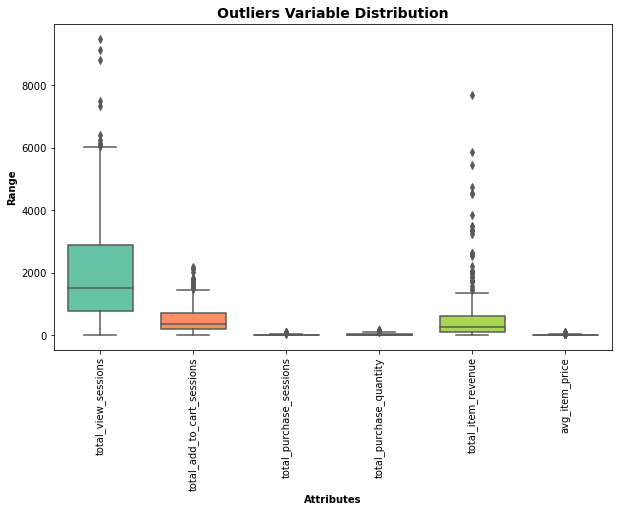

In [8]:
temp = ecommerce_item_america.copy()

attributes = temp.columns.drop('item_name')
sns.boxplot(data = temp[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'total_view_sessions'),
  Text(1, 0, 'total_add_to_cart_sessions'),
  Text(2, 0, 'total_purchase_sessions'),
  Text(3, 0, 'total_purchase_quantity'),
  Text(4, 0, 'total_item_revenue'),
  Text(5, 0, 'avg_item_price')])

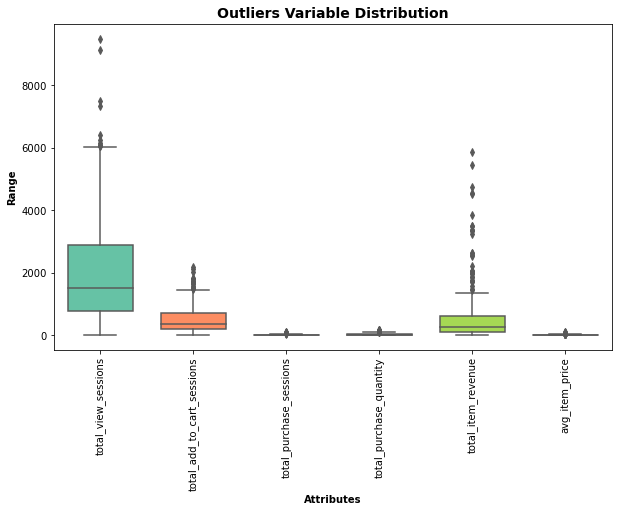

In [9]:
def removing_outliers(df):
    
    columns = list(df.drop(columns='item_name'))
    
    for i in columns:
        Q1 = df[i].quantile(0.05)
        Q3 = df[i].quantile(0.95)
        IQR = Q3 - Q1
        df = df[(df[i] >= Q1 - 1.5*IQR) & (df[i] <= Q3 + 1.5*IQR)]

    return df

outliers_removed_df = removing_outliers(temp)

attributes = outliers_removed_df.columns.drop('item_name')
sns.boxplot(data = outliers_removed_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.xticks(rotation=90)

In [10]:
before_removing_outliers_items = set(temp.item_name)
after_removing_outliers_items = set(outliers_removed_df.item_name)

outlier_items = before_removing_outliers_items - after_removing_outliers_items
outlier_items

{'Google Zip Hoodie F/C'}

### Cluster Analysis
After comparing clustering performance of K-means Clustering with that of Kohonen Clustering Network by looking into distance between clusters and standard deviations of each cluster, we choose the analysis results from __the latter one__, which performs better (standard deviations of most clusters are lower).

In [11]:
for_clustering = ecommerce_item_america.copy()
for_clustering.describe()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,2112.645914,531.350195,23.396887,38.548638,641.688716,15.948912
std,1804.109502,478.738220,20.490234,36.803938,1056.063114,17.494634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,794.000000,199.000000,9.000000,14.000000,99.000000,3.454545
50%,1519.000000,362.000000,19.000000,29.000000,273.000000,12.142857
75%,2886.000000,714.000000,30.000000,52.000000,631.000000,19.777778
max,9489.000000,2179.000000,121.000000,187.000000,7680.000000,99.157895


#### Standardization (Z-score Normalization)
In cluster analysis, groups are defined based on the distance between points in mathematical space. Hence, before conducting the analysis, it's important to rescale the values of the variables in the dataset by feature scaling so they share a common scale.

In [12]:
data_to_standardize = for_clustering.iloc[:,1:]

# standardization
X = (data_to_standardize-data_to_standardize.mean()) / data_to_standardize.std()
X.head()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
0,-0.616174,-0.433118,-0.214585,0.691539,-0.160680,-0.534387
1,0.130454,0.099532,-0.653818,-0.667011,-0.468427,-0.304866
3,-0.884451,-0.708843,-0.995444,-0.911550,-0.529977,0.017210
5,-0.409424,-0.585602,-0.458603,-0.667011,-0.240221,0.672513
6,-0.245909,-0.286900,0.322257,0.148119,-0.181513,-0.318983


#### The Elbow Method
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish.

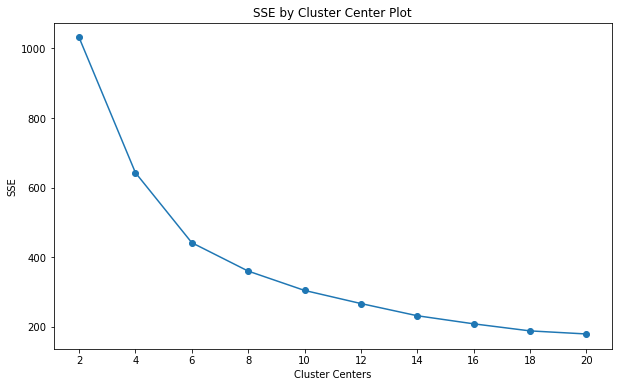

In [13]:
def find_optimal_clusters_sse(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    silhouettes = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)       
        sse.append(kmeans.inertia_)
        
#         labels = kmeans.predict(data)
#         silhouette_score = silhouette_score(data, labels)
#         silhouettes.append(silhouette_score)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters_sse(X, 20)

#### The Silhouette Method
The silhouette score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). A high value is desirable.

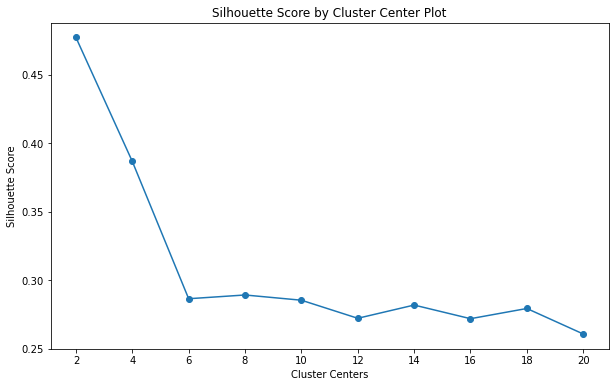

In [14]:
def find_optimal_clusters_silhouette(data, max_k):
    iters = range(2, max_k+1, 2)
    
    silhouettes = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)       
        
        labels = kmeans.predict(data)
        silhouette_score_ = silhouette_score(data, labels)
        silhouettes.append(silhouette_score_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouettes, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score by Cluster Center Plot')
    
find_optimal_clusters_silhouette(X, 20)

#### Determine the value of K
From the charts above, we can see k=6 is the inflection point; however, the Silhouette score as k=6 is too low. Therefore, __we choose k=4 for clustering__.

In [15]:
n_clusters = 4

#### PCA plot

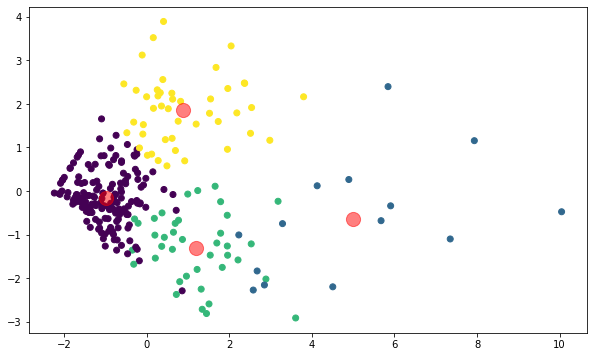

In [16]:
cls = KMeans(n_clusters, random_state=0)
cls.fit(X)

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], c='red', s=200, alpha=0.5)

#### #1 K-means Clustering

In [17]:
# number of clusters
kmeans = KMeans(n_clusters, random_state=3)

# fit the input data and tag clusters
res = kmeans.fit(X)
labels = kmeans.predict(X)

# item with its cluster tag
k1 = DataFrame(for_clustering.iloc[:,0])
k2 = DataFrame(labels)

# item count of each cluster
label_res = pd.merge(k1,k2, left_index=True, right_index=True).rename(columns={0: "cluster"})
label_res.groupby(['cluster'])['item_name'].agg('count')

cluster
0    25
1    98
2     9
3    19
Name: item_name, dtype: int64

In [18]:
# centroid values
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids)

cluster_result = pd.merge(data_to_standardize, label_res, left_index=True, right_index=True)
cluster_centroids = cluster_result.groupby(['cluster']).mean()

# calculate add-to-cart rate and CVR for each cluster based on the result
cluster_centroids['add_to_cart_%'] = cluster_centroids['total_add_to_cart_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids['conversion_%'] = cluster_centroids['total_purchase_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids[['total_view_sessions', 'total_add_to_cart_sessions', 'add_to_cart_%', 'total_purchase_sessions', 'conversion_%', 'total_purchase_quantity', 'total_item_revenue', 'avg_item_price']]

,total_view_sessions,total_add_to_cart_sessions,add_to_cart_%,total_purchase_sessions,conversion_%,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,,,
0,1783.000000,467.760000,26.234436,18.480000,1.036455,32.280000,305.280000,9.697673
1,2186.857143,569.673469,26.049871,24.530612,1.121729,38.183673,748.969388,17.560453
2,1914.666667,489.333333,25.557103,29.888889,1.561049,46.777778,720.666667,17.640442
3,2222.157895,545.210526,24.535184,19.578947,0.881078,32.315789,348.157895,12.169871


In [19]:
# standard deviations of each cluster
cluster_result.groupby(['cluster']).std()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,
0,1533.488208,483.908504,15.814339,32.473733,348.034304,8.462718
1,1661.574263,481.570857,21.389950,34.723754,1186.210717,18.315099
2,1658.735060,410.425998,23.866527,42.325459,1099.848399,29.629465
3,1871.704193,397.645931,17.771124,37.884404,288.321630,10.830459


#### #2 Kohonen Clustering Network

In [29]:
X_array = X.to_numpy()
som = SOM(m=4, n=1, dim=6)

res = som.fit(X_array)
labels = som.predict(X_array)

# item with its cluster tag
k1 = DataFrame(for_clustering.iloc[:,0])
k2 = DataFrame(labels)

# item count of each cluster
label_res = pd.merge(k1,k2, left_index=True, right_index=True).rename(columns={0: "cluster"})
label_res.groupby(['cluster'])['item_name'].agg('count')

cluster
0    61
1    46
2    27
3    17
Name: item_name, dtype: int64

In [30]:
# centroid values
centroids = som.cluster_centers_
centroids = pd.DataFrame(centroids[:,0])

cluster_result = pd.merge(data_to_standardize, label_res, left_index=True, right_index=True)
cluster_centroids = cluster_result.groupby(['cluster']).mean()

# calculate add-to-cart rate and CVR for each cluster based on the result
cluster_centroids['add_to_cart_%'] = cluster_centroids['total_add_to_cart_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids['conversion_%'] = cluster_centroids['total_purchase_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids[['total_view_sessions', 'total_add_to_cart_sessions', 'add_to_cart_%', 'total_purchase_sessions', 'conversion_%', 'total_purchase_quantity', 'total_item_revenue', 'avg_item_price']]

,total_view_sessions,total_add_to_cart_sessions,add_to_cart_%,total_purchase_sessions,conversion_%,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,,,
0,2395.327869,613.147541,25.597646,25.704918,1.073127,38.918033,810.606557,17.729472
1,1965.956522,524.347826,26.671385,21.934783,1.115731,35.717391,584.391304,15.980358
2,1713.777778,466.185185,27.202196,17.444444,1.017894,29.259259,289.407407,9.480092
3,2089.352941,480.941176,23.018666,27.000000,1.292266,45.705882,587.588235,16.517702


In [31]:
# standard deviations of each cluster
cluster_result.groupby(['cluster']).std()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,
0,1764.801544,500.749000,21.229181,32.515789,1290.613940,18.270858
1,1496.476721,447.280634,19.702681,34.935918,908.065575,17.103923
2,1390.797484,452.959587,19.141846,32.921343,361.470316,8.727201
3,2016.152801,404.914570,19.959334,46.541332,809.430360,22.936015


According to the results, we can group those top items among customers in Northern America into 4 clusters:

* __Cluster #1__: Items like "Google Crewneck Sweatshirt Navy" and "Google Badge Heavyweight Pullover Black" are highly viewed and added to cart by customers, however, the CVR of those items are relatively lower than other groups of items. If customers actually purchase those items, it will bring us revenue due to the high item prices. Moreover, top items in this group are mostly in "Apparel" category.


* __Cluster #2__: Items such as "Google Crewneck Sweatshirt Green" and "Google Canteen Bottle Black" are similar to items in cluster #1, but sessions of viewing/add-to-cart and revenue from those items are lower. Also, we can find that besides items in "Apparel" category, there're some popular products in "Lifestyle" category as well.


* __Cluster #3__: Items including "Google Land & Sea Cotton Cap" and "Google KeepCup" slightly viewed by customers compared to items in other groups, but the add-to-cart rates of those items are relatively high. Profits from those items are low because most of them are inexpensive products in "Lifestyle" and "Stationery" categories.


* __Cluster #4__: Items as "Google Men's Puff Jacket Black" and "Google Heather Green Speckled Tee" have high add-to-cart rates and CVRs, which indicates that items in this group are pretty popular among customers.

The following are high-value items in each group, ordering by total item revenue:

In [38]:
# top 5 products in each cluster ordering by item revenue

print(cluster_result[cluster_result.cluster == 0].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 1].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 2].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 3].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))

108            Google Campus Bike Eco Tee Navy
44              Android SM S/F18 Sticker Sheet
32       Android Large Removable Sticker Sheet
70     Google Badge Heavyweight Pullover Black
150            Google Crewneck Sweatshirt Navy
Name: item_name, dtype: object
157      Google F/C Long Sleeve Tee Ash
169         Google Heathered Pom Beanie
148    Google Crewneck Sweatshirt Green
202       Google Land & Sea Journal Set
47         Android Techie 3D Framed Art
Name: item_name, dtype: object
200         Google Land & Sea Cotton Cap
45     Android Small Trace Journal Black
22              Android Iconic Hat Black
217              Google Large Tote White
21     Android Iconic Glass Bottle Green
Name: item_name, dtype: object
201    Google Land & Sea French Terry Sweatshirt
158          Google F/C Long Sleeve Tee Charcoal
168            Google Heather Green Speckled Tee
252                        Google Mouse Pad Navy
234               Google Men's Puff Jacket Black
Name: item_name, dtype

## #2 Sessions of Customers in Southern & Eastern Asia

### Data Preparation for Clustering
* `total_view_sessions` : __(if viewed)__ number of unique sessions viewed this item
* `total_add_to_cart_sessions`: __(if added)__ number of unique sessions added this item to cart
* `total_purchase_sessions`: __(if purchased)__ number of unique sessions purchased this item
* `total_purchase_quantity`: __(if purchased)__ total quantity this item was purchased
* `total_item_revenue`: __(if purchased)__ total purchase revenue of this item
* `avg_item_price`: __(if purchased)__ average price of this item among all transactions

Note: The correlation between customers and sessions are extremely high __(more than 0.99)__, which indicates customers seldom revisit site/repurchase items (or maybe customers get new `user_pseudo_id` after their first purchase), so we choose __sessions__ as our metrics for modeling.

In [111]:
### view events
view_item_events_asia = ecommerce_asia[((ecommerce_asia.event_name == 'view_item') | (ecommerce_asia.event_name == 'select_item')) &
                                       (ecommerce_asia.item_category.isnull() == False)]

# # total_view_customers
# total_view_customers_asia = view_item_events_asia.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                             reset_index().rename(columns={'user_pseudo_id':'total_view_customers'})

# total_view_sessions
total_view_sessions_asia = view_item_events_asia.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                           reset_index().rename(columns={'unique_session_id':'total_view_sessions'})

# view item data
view_item_asia = total_view_sessions_asia


### add_to_cart events
add_to_cart_item_events_asia = ecommerce_asia[(ecommerce_asia.event_name == 'add_to_cart')]

# # total_add_to_cart_customers
# total_add_to_cart_customers_asia = add_to_cart_item_events_asia.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                                    reset_index().rename(columns={'user_pseudo_id':'total_add_to_cart_customers'})

# total_add_to_cart_sessions
total_add_to_cart_sessions_asia = add_to_cart_item_events_asia.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                                  reset_index().rename(columns={'unique_session_id':'total_add_to_cart_sessions'})

# add_to_cart item data
add_to_cart_item_asia = total_add_to_cart_sessions_asia


### purchase events
purchase_item_events_asia = ecommerce_asia[(ecommerce_asia.event_name == 'purchase') & (ecommerce_asia.event_value_in_usd.isnull() == False)]

# # total_purchase_customers
# total_purchase_customers_asia = purchase_item_events_asia.groupby(['item_name'])['user_pseudo_id'].agg('nunique').\
#                                 reset_index().rename(columns={'user_pseudo_id':'total_purchase_customers'})

# total_purchase_sessions
total_purchase_sessions_asia = purchase_item_events_asia.groupby(['item_name'])['unique_session_id'].agg('nunique').\
                               reset_index().rename(columns={'unique_session_id':'total_purchase_sessions'})

# total_purchase_quantity
total_purchase_quantity_asia = purchase_item_events_asia.groupby(['item_name'])['quantity'].agg('sum').\
                               reset_index().rename(columns={'quantity':'total_purchase_quantity'})

# total_item_revenue
total_item_revenue_asia = purchase_item_events_asia.groupby(['item_name'])['item_revenue_in_usd'].agg('sum').\
                          reset_index().rename(columns={'item_revenue_in_usd':'total_item_revenue'})

# avg_item_price
avg_item_price = purchase_item_events_asia.groupby(['item_name'])['price_in_usd'].agg('mean').\
                 reset_index().rename(columns={'price_in_usd':'avg_item_price'})

# purchase item data
purchase_item_asia = total_purchase_sessions_asia.merge(total_purchase_quantity_asia).merge(total_item_revenue_asia).merge(avg_item_price)


### final data
ecommerce_item_asia = view_item_asia.merge(add_to_cart_item_asia, how='outer').merge(purchase_item_asia, how='outer').fillna(0)
ecommerce_item_asia

,item_name,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
0,#IamRemarkable Journal,331.0,112.0,8.0,12.0,75.0,6.181818
1,#IamRemarkable Ladies T-Shirt,739.0,191.0,2.0,4.0,40.0,10.000000
2,#IamRemarkable Lapel Pin,91.0,23.0,1.0,1.0,2.0,2.000000
3,#IamRemarkable Pen,175.0,66.0,2.0,3.0,45.0,15.000000
4,#IamRemarkable Tote,45.0,13.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
423,Google Unisex Eco Tee Black,0.0,0.0,23.0,29.0,537.0,18.592593
424,Unisex Google Jumbo Print Tee White,0.0,0.0,1.0,1.0,12.0,12.000000
425,Unisex Google Pocket Tee Grey,0.0,0.0,7.0,8.0,152.0,19.000000
426,Womens Google Striped LS,0.0,0.0,12.0,12.0,196.0,16.333333


In [112]:
ecommerce_item_asia.describe()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,430.093458,105.135514,5.175234,8.887850,137.957944,14.066984
std,544.938641,141.014957,6.091007,15.963704,283.377237,17.167137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.500000,13.000000,1.000000,1.000000,7.000000,2.000000
50%,197.500000,46.000000,3.000000,4.000000,43.500000,10.062500
75%,565.000000,137.000000,7.000000,11.000000,137.250000,18.078125
max,3028.000000,712.000000,41.000000,199.000000,2362.000000,108.000000


In [113]:
# focus on popular items (which value is greater than at most 50% of all data points)
ecommerce_item_asia = ecommerce_item_asia[(ecommerce_item_asia.total_view_sessions >= 197) \
                                          | (ecommerce_item_asia.total_add_to_cart_sessions >= 46) \
                                          | (ecommerce_item_asia.total_purchase_sessions >= 3)]
ecommerce_item_asia.item_name.nunique()

316

In [114]:
# pearson correlation between metrics
cormat = ecommerce_item_asia.corr(method='pearson')
cormat.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
total_view_sessions,1.00,0.96,0.36,0.15,0.35,0.13
total_add_to_cart_sessions,0.96,1.00,0.39,0.17,0.36,0.09
total_purchase_sessions,0.36,0.39,1.00,0.69,0.70,0.23
total_purchase_quantity,0.15,0.17,0.69,1.00,0.42,0.00
total_item_revenue,0.35,0.36,0.70,0.42,1.00,0.63
avg_item_price,0.13,0.09,0.23,0.00,0.63,1.00


### (Optional) Remove Outliers

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'total_view_sessions'),
  Text(1, 0, 'total_add_to_cart_sessions'),
  Text(2, 0, 'total_purchase_sessions'),
  Text(3, 0, 'total_purchase_quantity'),
  Text(4, 0, 'total_item_revenue'),
  Text(5, 0, 'avg_item_price')])

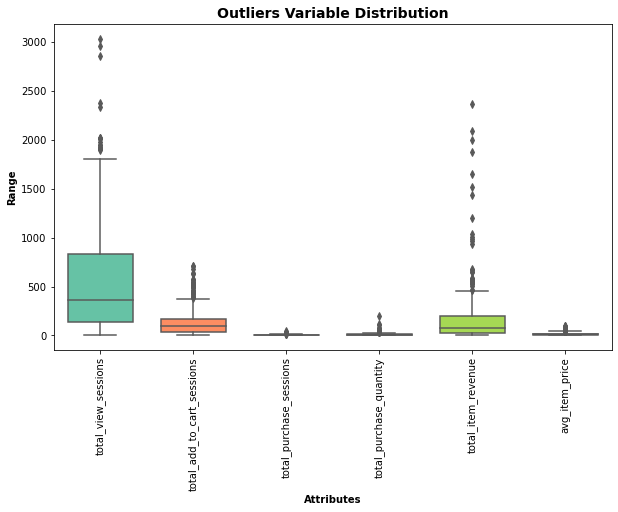

In [115]:
temp = ecommerce_item_asia.copy()

attributes = temp.columns.drop('item_name')
sns.boxplot(data = temp[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'total_view_sessions'),
  Text(1, 0, 'total_add_to_cart_sessions'),
  Text(2, 0, 'total_purchase_sessions'),
  Text(3, 0, 'total_purchase_quantity'),
  Text(4, 0, 'total_item_revenue'),
  Text(5, 0, 'avg_item_price')])

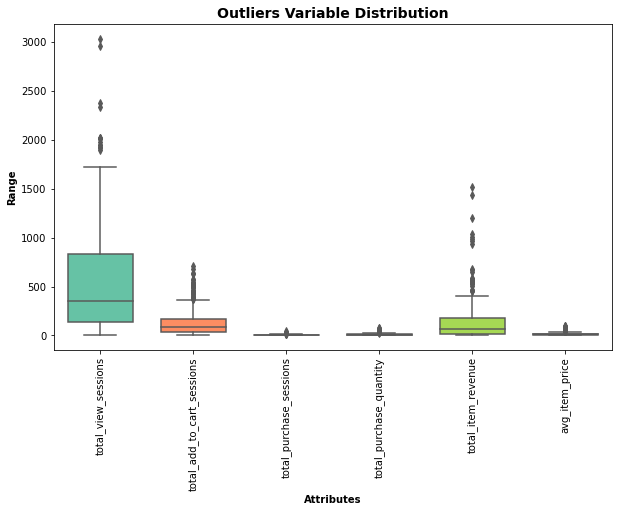

In [116]:
def removing_outliers(df):
    
    columns = list(df.drop(columns='item_name'))
    
    for i in columns:
        Q1 = df[i].quantile(0.05)
        Q3 = df[i].quantile(0.95)
        IQR = Q3 - Q1
        df = df[(df[i] >= Q1 - 1.5*IQR) & (df[i] <= Q3 + 1.5*IQR)]

    return df

outliers_removed_df = removing_outliers(temp)

attributes = outliers_removed_df.columns.drop('item_name')
sns.boxplot(data = outliers_removed_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.xticks(rotation=90)

In [117]:
before_removing_outliers_items = set(temp.item_name)
after_removing_outliers_items = set(outliers_removed_df.item_name)

outlier_items = before_removing_outliers_items - after_removing_outliers_items
outlier_items

{'Google Badge Heavyweight Pullover Black',
 'Google Clear Pen 4-Pack',
 'Google Crewneck Sweatshirt Navy',
 'Google Incognito Techpack V2',
 'Google Laptop and Cell Phone Stickers',
 "Google Men's Tech Fleece Grey",
 'Google Metallic Notebook Set',
 'Google Zip Hoodie F/C'}

### Cluster Analysis
After comparing clustering performance of K-means Clustering with that of Kohonen Clustering Network by looking into distance between clusters and standard deviations of each cluster, we choose the analysis results from __the latter one__, which performs better (standard deviations of most clusters are lower).

In [137]:
for_clustering = ecommerce_item_asia.copy()
for_clustering.describe()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,564.015823,138.484177,6.696203,11.594937,179.825949,15.395577
std,577.007444,150.529277,6.416951,17.778010,318.876079,17.145390
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,138.000000,34.000000,3.000000,3.000000,20.750000,3.309375
50%,363.500000,92.000000,5.000000,7.000000,72.000000,11.250000
75%,834.250000,169.250000,9.000000,14.000000,196.000000,19.785714
max,3028.000000,712.000000,41.000000,199.000000,2362.000000,100.800000


#### Standardization (Z-score Normalization)
In cluster analysis, groups are defined based on the distance between points in mathematical space. Hence, before conducting the analysis, it's important to rescale the values of the variables in the dataset by feature scaling so they share a common scale.

In [119]:
data_to_standardize = for_clustering.iloc[:,1:]

# standardization
X = (data_to_standardize-data_to_standardize.mean()) / data_to_standardize.std()
X.head()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
0,-0.403835,-0.175940,0.203180,0.022785,-0.328736,-0.537390
1,0.303262,0.348874,-0.731843,-0.427210,-0.438496,-0.314696
3,-0.674196,-0.481529,-0.731843,-0.483459,-0.422816,-0.023072
5,-0.242659,-0.381880,-0.420169,0.079034,0.486628,0.618500
6,-0.062418,-0.043076,-0.264332,-0.258462,-0.338144,-0.298031


#### The Elbow Method
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish.

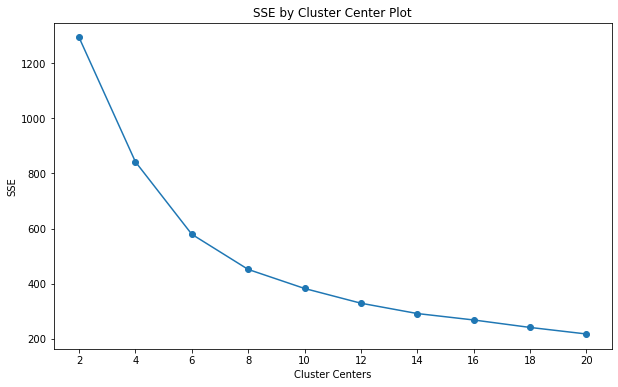

In [120]:
def find_optimal_clusters_sse(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    silhouettes = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)       
        sse.append(kmeans.inertia_)
        
#         labels = kmeans.predict(data)
#         silhouette_score = silhouette_score(data, labels)
#         silhouettes.append(silhouette_score)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters_sse(X, 20)

#### The Silhouette Method
The silhouette score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). A high value is desirable.

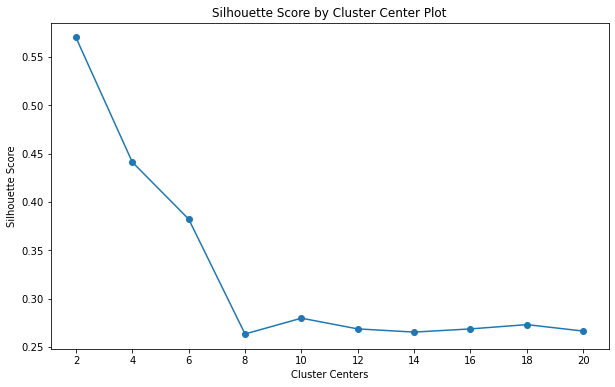

In [121]:
def find_optimal_clusters_silhouette(data, max_k):
    iters = range(2, max_k+1, 2)
    
    silhouettes = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)       
        
        labels = kmeans.predict(data)
        silhouette_score_ = silhouette_score(data, labels)
        silhouettes.append(silhouette_score_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouettes, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score by Cluster Center Plot')
    
find_optimal_clusters_silhouette(X, 20)

#### Determine the value of K
From the charts above, we can see k=6 is the inflection point; however, the Silhouette score of k=6 is lower than that of k=4. Therefore, __we choose k=4 for clustering__.

In [149]:
n_clusters = 4

#### PCA plot

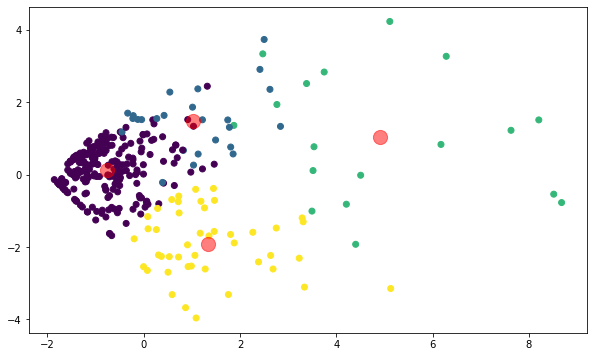

In [150]:
cls = KMeans(n_clusters, random_state=0)
cls.fit(X)

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], c='red', s=200, alpha=0.5)

#### #1 K-means Clustering

In [151]:
# number of clusters
kmeans = KMeans(n_clusters, random_state=5)

# fit the input data and tag clusters
res = kmeans.fit(X)
labels = kmeans.predict(X)

# item with its cluster tag
k1 = DataFrame(for_clustering.iloc[:,0])
k2 = DataFrame(labels)

# item count of each cluster
label_res = pd.merge(k1,k2, left_index=True, right_index=True).rename(columns={0: "cluster"})
label_res.groupby(['cluster'])['item_name'].agg('count')

cluster
0    167
1     33
2     11
3     17
Name: item_name, dtype: int64

In [152]:
# centroid values
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids)

cluster_result = pd.merge(data_to_standardize, label_res, left_index=True, right_index=True)
cluster_centroids = cluster_result.groupby(['cluster']).mean()

# calculate add-to-cart rate and CVR for each cluster based on the result
cluster_centroids['add_to_cart_%'] = cluster_centroids['total_add_to_cart_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids['conversion_%'] = cluster_centroids['total_purchase_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids[['total_view_sessions', 'total_add_to_cart_sessions', 'add_to_cart_%', 'total_purchase_sessions', 'conversion_%', 'total_purchase_quantity', 'total_item_revenue', 'avg_item_price']]

,total_view_sessions,total_add_to_cart_sessions,add_to_cart_%,total_purchase_sessions,conversion_%,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,,,
0,514.329341,129.850299,25.246528,6.778443,1.317919,11.892216,189.502994,15.740838
1,517.636364,138.848485,26.823557,6.242424,1.205948,12.303030,141.212121,10.968053
2,490.000000,97.818182,19.962894,4.636364,0.946197,12.636364,56.454545,4.543561
3,702.000000,174.647059,24.878498,8.529412,1.215016,12.352941,194.529412,16.127992


In [153]:
# standard deviations of each cluster
cluster_result.groupby(['cluster']).std()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,
0,526.289014,140.117835,5.981297,19.831528,350.974459,16.816777
1,532.070943,160.166148,5.921520,14.364637,286.094036,12.572485
2,361.778109,68.202373,7.990904,30.771002,98.042199,4.527697
3,809.274135,195.606091,7.107370,10.258784,271.911088,19.293433


#### #2 Kohonen Clustering Network

In [154]:
X_array = X.to_numpy()
som = SOM(m=4, n=1, dim=6)

res = som.fit(X_array)
labels = som.predict(X_array)

# item with its cluster tag
k1 = DataFrame(for_clustering.iloc[:,0])
k2 = DataFrame(labels)

# item count of each cluster
label_res = pd.merge(k1,k2, left_index=True, right_index=True).rename(columns={0: "cluster"})
label_res.groupby(['cluster'])['item_name'].agg('count')

cluster
0     20
1     38
2    118
3     52
Name: item_name, dtype: int64

In [155]:
# centroid values
centroids = som.cluster_centers_
centroids = pd.DataFrame(centroids[:,0])

cluster_result = pd.merge(data_to_standardize, label_res, left_index=True, right_index=True)
cluster_centroids = cluster_result.groupby(['cluster']).mean()

# calculate add-to-cart rate and CVR for each cluster based on the result
cluster_centroids['add_to_cart_%'] = cluster_centroids['total_add_to_cart_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids['conversion_%'] = cluster_centroids['total_purchase_sessions'] / cluster_centroids['total_view_sessions'] * 100
cluster_centroids[['total_view_sessions', 'total_add_to_cart_sessions', 'add_to_cart_%', 'total_purchase_sessions', 'conversion_%', 'total_purchase_quantity', 'total_item_revenue', 'avg_item_price']]

,total_view_sessions,total_add_to_cart_sessions,add_to_cart_%,total_purchase_sessions,conversion_%,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,,,
0,492.150000,111.300000,22.615056,6.650000,1.351214,13.950000,102.650000,7.431498
1,639.710526,156.973684,24.538237,7.000000,1.094245,16.657895,187.157895,16.773883
2,489.483051,123.135593,25.156253,6.779661,1.385066,10.347458,174.279661,14.425022
3,545.923077,145.980769,26.740172,6.442308,1.180076,11.692308,202.019231,15.896744


In [156]:
# standard deviations of each cluster
cluster_result.groupby(['cluster']).std()

,total_view_sessions,total_add_to_cart_sessions,total_purchase_sessions,total_purchase_quantity,total_item_revenue,avg_item_price
cluster,,,,,,
0,419.059633,112.840409,8.196758,23.571783,164.401394,9.314685
1,717.423465,182.654819,6.311722,33.598002,300.449530,19.084658
2,499.409613,130.676407,5.863308,13.325881,342.008819,15.713840
3,544.811925,157.105621,6.004617,13.079753,367.642276,16.951966


According to the results, we can group those top items among customers in Southern & Eastern Asia into 4 clusters:

* __Cluster #1__: Items like "Google Clear Pen 4-Pack" and "Google Magnet" have high CVRs but low revenue, which are mostly categorized in "Stationery" category. 


* __Cluster #2__: Items such as "Google Crewneck Sweatshirt Green" and "Google Sherpa Zip Hoodie Charcoal" are highly viewed and added to cart by customers, however, the CVRs of those items are relatively lower than other groups of items. This group is similar to Cluster #1 in North America.


* __Cluster #3__: Items including "Google Men's Tech Fleece Grey" and " Google Badge Heavyweight Pullover Black" have high add-to-cart rates and CVRs, and those items bring us great revenue because of their high prices. They are products that we can focus on promoting in this region.


* __Cluster #4__: Items as "Google Crewneck Sweatshirt Navy" and "Google Crewneck Sweatshirt Grey" are similar to items in Cluster #3 but with lower CVRs. Those are the second priority we can promote.

The following are high-value items in each group, ordering by total item revenue:

In [157]:
# top 5 products in each cluster ordering by item revenue

print(cluster_result[cluster_result.cluster == 0].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 1].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 2].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))
print(cluster_result[cluster_result.cluster == 3].sort_values(by='total_item_revenue', ascending=False)['item_name'].head(5))

144             Google Cotopaxi Shell
169       Google Heathered Pom Beanie
126           Google Clear Pen 4-Pack
226                     Google Magnet
161    Google Felt Refillable Journal
Name: item_name, dtype: object
148         Google Crewneck Sweatshirt Green
313        Google Sherpa Zip Hoodie Charcoal
266                 Google Navy Speckled Tee
210    Google Laptop and Cell Phone Stickers
215       Google Large Standard Journal Grey
Name: item_name, dtype: object
235              Google Men's Tech Fleece Grey
70     Google Badge Heavyweight Pullover Black
236     Google Men's Tech Fleece Vest Charcoal
233             Google Men's Puff Jacket Black
314              Google Sherpa Zip Hoodie Navy
Name: item_name, dtype: object
150    Google Crewneck Sweatshirt Navy
175       Google Incognito Techpack V2
149    Google Crewneck Sweatshirt Grey
265       Google NYC Campus Zip Hoodie
81               Google Blue Stojo Cup
Name: item_name, dtype: object
